# w261 Final Project EDA

#### Description:

This notebook shows the EDA performed for the w261 final project. This EDA started with taking a small random sample of the raw data and performing exploratory analysis with pandas packages.

#### Objectives for final project:
Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform.

#### The EDA comprises the following tasks:
- Understanding the data structure and composition of the features in the dataset.
- Plotting the target and numerical variables to understand their distributions in order to make decisions about the type of transformations required. 
    - For instance, if numerical variables are ordinal in nature, performing appropriate bucketing of the variables or one-hot encoding to ensure each value is captured in the data for analysis.
- Displaying the distribution of the categorical variables to understand their distributions in order to make decision about the bucketing or one-hot encoding required.

### Load libraries

In [3]:
# General tools & operations libraries
import re
import ast
import time
import csv
import itertools
import math
from statsmodels.stats.stattools import durbin_watson

# Mathematical operations and dataframes libraries
import numpy as np
import pandas as pd

# Plotting and visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

Spark is not required for this analysis, no the following codeblock is commented out.

In [2]:
# # start Spark Session (RUN THIS CELL AS IS)
# from pyspark.sql import SparkSession
# app_name = "finalproject_notebook"
# master = "local[*]"
# spark = SparkSession\
#         .builder\
#         .appName(app_name)\
#         .master(master)\
#         .getOrCreate()
# sc = spark.sparkContext

In [1]:
# # Spark configuration Information (RUN THIS CELL AS IS)
# sc.getConf().getAll()

In [7]:
# spark

### Note about the dataset

The datasets for the Kaggle Display Advertising Competition are downloaded from the Criteo Labs competition site and are hosted as a compressed `.tar` file in an `S3` bucket here:
https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

The full raw `train.txt` dataset is 11.15GB in size and is too large to read into conventional Jupyter Notebooks to perform analysis. Moreover, as we will discuss later, there are significant dimensionality constraints that inhibit loading the entire dataset and performing conventional one-hot encoding on the entire dataset. A solution is required to analyze the data and perform an algorithm implementation at scale.

Therefore, we load a random sample of the dataset representing just 0.1% of the dataset. While this represents a small portion of the entire raw dataset, we believe this gives us a representative sample that will allow us to understand the dataset's features, data structure and distributions in preparation for an analysis and predictive modeling at scale.

### Load dataset

Full dataset to be used for analysis:

http://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset//

https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

Change directory

In [8]:
cd '/Volumes/LaCie/dac'

/Volumes/LaCie/dac


In [9]:
# assign parameters
!BUCKET=danielalvarez_w261projects

The following command line snippet is shown for exposition as to how we took a 0.1% random sample. This data is 11.4MB in size. It is commented out since it was just needed to produce the toy example one time. 

In [4]:
!cat train.txt | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .001) print $0}' > data/sample.txt
#!gzip -cd data/dac.tar.gz | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .001) print $0}' > data/sample.txt

Next, we inspect the sample .`txt` data. We note that there are 46,048 lines in the dataset.

In [10]:
# check number of lines, byte and characters count
!wc data/sample.txt

   46048 1586737 11196195 data/sample.txt


In [11]:
# inspect first line to get a sense of the overall schema
!head -n 1 data/sample.txt

0	1	2	2	2	292	2	1	2	2	1	1		2	05db9164	0a519c5c	b00d1501	d16679b9	25c83c98	7e0ccccf	1683df22	0b153874	a73ee510	3b08e48b	89073265	e0d76380	8b266858	b28479f6	b760dcb7	1203a270	d4bb7bd8	2efa89c6			73d06dde		3a171ecb	aee52b6f		


Next, we impose a schema structure over the 40 variables. We note that:

- feature in position 0 is the target label, `y`
- feature in the 13th position is numeric (`n13`)
- features in the 14th through 39th position are categorical

In [15]:
# convert txt file into a csv file
with open('data/sample.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open('data/sample.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('title', 'intro'))
        writer.writerows(lines)

In [16]:
# Assign parameters
chunksize = 327433
file = 'data/sample.csv'

Read in dataset

In [17]:
column_names = ['y','n1','n2','n3','n4','n5','n6',
                'n7','n8','n9','n10','n11', 'n12', 'n13',
                'cat14','cat15','cat16','cat17','cat18',
                'cat19','cat20','cat21','cat22','cat23','cat24',
                'cat25','cat26','cat27','cat28','cat29','cat30',
                'cat31','cat32','cat33','cat34','cat35','cat36',
                'cat37','cat38','cat39']

In [18]:
df = pd.read_csv('data/sample.csv', sep="\t", names=column_names, chunksize=chunksize, engine='python')

In [19]:
df_sample = df.get_chunk()
df_sample.shape

(46049, 40)

First, we assess the data structure, data types and non-null values for each feature

In [20]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46049 entries, 0 to 46048
Data columns (total 40 columns):
y        46049 non-null object
n1       25374 non-null float64
n2       46048 non-null float64
n3       36219 non-null float64
n4       36054 non-null float64
n5       44940 non-null float64
n6       35770 non-null float64
n7       44042 non-null float64
n8       46018 non-null float64
n9       44042 non-null float64
n10      25374 non-null float64
n11      44042 non-null float64
n12      10829 non-null float64
n13      36054 non-null float64
cat14    46048 non-null object
cat15    46048 non-null object
cat16    44475 non-null object
cat17    44475 non-null object
cat18    46048 non-null object
cat19    40458 non-null object
cat20    46048 non-null object
cat21    46048 non-null object
cat22    46048 non-null object
cat23    46048 non-null object
cat24    46048 non-null object
cat25    44475 non-null object
cat26    46048 non-null object
cat27    46048 non-null object
cat28    4

Inspect top 5 rows

In [21]:
df_sample.head()

,y,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39
0,"title,intro",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,0,1.0,2.0,2.0,2.0,292.0,2.0,1.0,2.0,2.0,...,d4bb7bd8,2efa89c6,NaN,NaN,73d06dde,NaN,3a171ecb,aee52b6f,None,None
2,0,NaN,-1.0,86.0,1.0,6147.0,875.0,3.0,1.0,96.0,...,e5ba7672,47e4d79e,9437f62f,a458ea53,d2bc432c,NaN,bcdee96c,b0a08858,c9f3bea7,553d46e8
3,0,1.0,1.0,16.0,2.0,0.0,2.0,24.0,2.0,13.0,...,e5ba7672,e88ffc9d,efa3470f,b1252a9d,65229b6e,NaN,bcdee96c,3fdb382b,cb079c2d,64f08cc6
4,0,0.0,1.0,3.0,9.0,3195.0,57.0,3.0,35.0,120.0,...,e5ba7672,9dde83ca,NaN,NaN,831d5286,NaN,32c7478e,9e9a60e4,None,None


In [22]:
# Drop first row
df_sample.drop(df_sample.index[0]).head()

,y,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39
1,0,1.0,2.0,2.0,2.0,292.0,2.0,1.0,2.0,2.0,...,d4bb7bd8,2efa89c6,NaN,NaN,73d06dde,NaN,3a171ecb,aee52b6f,None,None
2,0,NaN,-1.0,86.0,1.0,6147.0,875.0,3.0,1.0,96.0,...,e5ba7672,47e4d79e,9437f62f,a458ea53,d2bc432c,NaN,bcdee96c,b0a08858,c9f3bea7,553d46e8
3,0,1.0,1.0,16.0,2.0,0.0,2.0,24.0,2.0,13.0,...,e5ba7672,e88ffc9d,efa3470f,b1252a9d,65229b6e,NaN,bcdee96c,3fdb382b,cb079c2d,64f08cc6
4,0,0.0,1.0,3.0,9.0,3195.0,57.0,3.0,35.0,120.0,...,e5ba7672,9dde83ca,NaN,NaN,831d5286,NaN,32c7478e,9e9a60e4,None,None
5,0,0.0,21.0,5.0,6.0,7460.0,192.0,2.0,24.0,153.0,...,07c540c4,7b49e3d2,NaN,NaN,73d06dde,NaN,3a171ecb,aee52b6f,None,None


In [23]:
# Assess percentage of label categories
df_sample.y.value_counts(dropna=False)/len(df_sample)

0              0.745554
1              0.254425
title,intro    0.000022
Name: y, dtype: float64

In [25]:
# Examine row with `label` value `title,intro`
df_sample[df_sample['y']=='title,intro']

,y,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39
0,"title,intro",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


Row with `label` value 'title,empty' is empty, so proceed to drop the row. Drop rows with label values not equal to `0` or `1`.

In [27]:
# Drop row with `label` value `title,intro`
df_sample = df_sample[(df_sample.y == '0') | (df_sample.y == '1')]

In [34]:
#convert `label` value to an integer value
df_sample['y'] = df_sample['y'].astype(str).astype(int)

## Sparseness of features (null values)

We observe the number of null values for each feature to assess sparseness.

In [35]:
# Number of null values for each feature and percentage of null values for each feature
print("{}\t| {:10s}\t| {:10s}".format("Feature","Null values","Null Values as a Percent of Total"))
print("="*100)
for col in df_sample.columns:
    null_values = df_sample[col].isnull().sum(axis=0)
    null_values_pct = df_sample[col].isnull().sum(axis=0)/len(df_sample) * 100
    print(" {}\t| {:6d}\t| {:6f}".format(str(col),null_values,null_values_pct))

Feature	| Null values	| Null Values as a Percent of Total
 y	|      0	| 0.000000
 n1	|  20674	| 44.896630
 n2	|      0	| 0.000000
 n3	|   9829	| 21.345118
 n4	|   9994	| 21.703440
 n5	|   1108	| 2.406185
 n6	|  10278	| 22.320188
 n7	|   2006	| 4.356324
 n8	|     30	| 0.065149
 n9	|   2006	| 4.356324
 n10	|  20674	| 44.896630
 n11	|   2006	| 4.356324
 n12	|  35219	| 76.483235
 n13	|   9994	| 21.703440
 cat14	|      0	| 0.000000
 cat15	|      0	| 0.000000
 cat16	|   1573	| 3.416001
 cat17	|   1573	| 3.416001
 cat18	|      0	| 0.000000
 cat19	|   5590	| 12.139507
 cat20	|      0	| 0.000000
 cat21	|      0	| 0.000000
 cat22	|      0	| 0.000000
 cat23	|      0	| 0.000000
 cat24	|      0	| 0.000000
 cat25	|   1573	| 3.416001
 cat26	|      0	| 0.000000
 cat27	|      0	| 0.000000
 cat28	|      0	| 0.000000
 cat29	|   1573	| 3.416001
 cat30	|      0	| 0.000000
 cat31	|      0	| 0.000000
 cat32	|  20280	| 44.041001
 cat33	|  20280	| 44.041001
 cat34	|   1573	| 3.416001
 cat35	|  35217	| 76.47889

We observe that there are several features with a large percentage of null values. Particularly, the features: `n1`, `n3`, `n4`, `n6`, `n10`, `n12`, `n13`, `cat32`, `cat33`, `cat35`, `cat38` and `cat39` each have over 20% of their values being null. We will have to make analytical choices about how we treat these null values.

## Imbalance in target label

Next, we assess the label values to observe class imbalance. This may affect the behavior of tree algorithms in particular, since it imposes a bias for the majority class in each tree split.

In [36]:
# Assess label categories
df_sample.y.value_counts(dropna=False)

0    34332
1    11716
Name: y, dtype: int64

In [38]:
# Assess percentage of label categories
df_sample.y.value_counts(dropna=False)/len(df_sample)

0    0.74557
1    0.25443
Name: y, dtype: float64

/anaconda/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


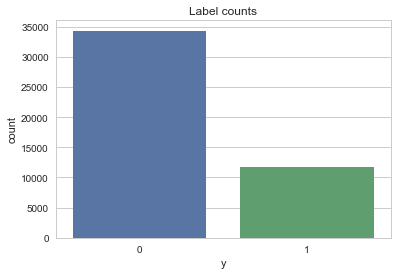

In [39]:
# plot distribution of label counts
sns.set(style="whitegrid")
ax = sns.countplot(x="y", data=df_sample)
ax.set(title="Label counts")
plt.show()

We observe that `y` target values equal to 0 are dominant, corresponding to around three-quarters of the dataset labels. 

## EDA - Mean and median values with respect to target label categories

Here, we explore mean values of numeric variables with respect to label target categories. This is important for creating recursive partitions of regions into homogeneous zones in tree-based algorithms.

In [40]:
df_sample.groupby(df_sample.y)['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10',
                               'n11', 'n12', 'n13'].mean()

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13
y,,,,,,,,,,,,,
0,2.890596,94.917977,21.962752,7.587890,22193.431860,137.943265,12.421027,12.756712,102.552015,0.538505,2.216218,0.617135,8.978133
1,4.853875,136.881188,27.669818,6.604589,9251.656253,64.945327,26.966072,11.939042,117.708464,0.804193,4.204704,1.765704,6.037941


Explore median values of numeric variables with respect to label target categories. This may allow us to more evenly split the numeric variables.

In [41]:
df_sample.groupby(df_sample.y)['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10',
                               'n11', 'n12', 'n13'].median()

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13
y,,,,,,,,,,,,,
0,1.0,3.0,7.0,4.0,3208.0,41.0,2.0,8.0,38.0,0.0,1.0,0.0,5.0
1,2.0,3.0,5.0,4.0,1342.0,14.0,6.0,7.0,38.0,1.0,2.0,0.0,3.0


## Correlation Heat Map of Numeric Variables

Correlation heat map of the numeric variables allows us to visualize whether there are non-orthogonal variables and whether we can reduce the dimensionality of our data in the modeling analysis.

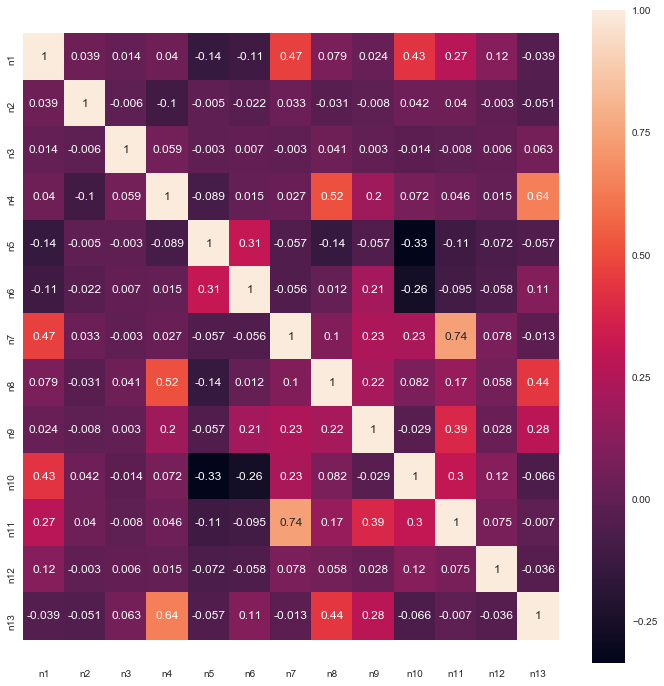

In [42]:
df_integers = df_sample.iloc[:,1:14]

var_corr = df_integers.corr()
var_corr = var_corr.round(3)
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)

# Fix axes
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

The most positively correlated feature pairs from this sample are:
- `n7` and `n11` (_p_ = .74 in this sample);
- `n4` and `n13` (_p_ = .6 in this sample);
- `n4` and `n8` (_p_ = .53 in this sample);
- `n7` and `n1` (_p_ = .4 in this sample);
- `n10` and `n1` (_p_ = .4 in this sample);

The most negatively correlated feature pairs from this sample are:
- `n5` and `n10` (_p_ = -.34 in this sample);
- `n6` and `n10` (_p_ = -.28 in this sample)

Following this correlation analysis, since we did not consider these features to be strongly correlated, we were not concerned with effects of multicollinearity and chose to keep these features for the modeling implementation.

Considering binning the integer variables to find the best split. Plot the histograms of each variable and see if equal-width lengths can be extracted. After, can be treated as an ordered categorical attribute. 

n1
[  0.   36.3  72.6 108.9 145.2 181.5 217.8 254.1 290.4 326.7 363. ]


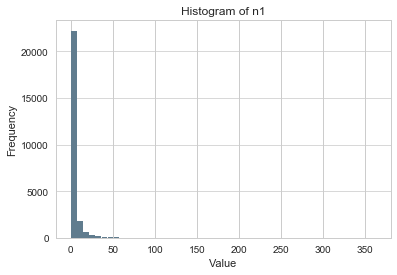

n2
[-2.00000e+00  1.43330e+03  2.86860e+03  4.30390e+03  5.73920e+03
  7.17450e+03  8.60980e+03  1.00451e+04  1.14804e+04  1.29157e+04
  1.43510e+04]


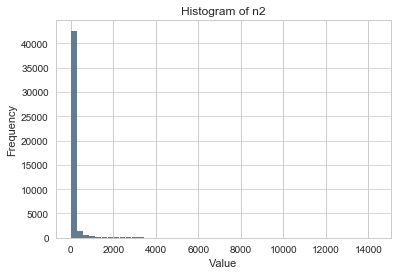

n3
[    0.   3724.3  7448.6 11172.9 14897.2 18621.5 22345.8 26070.1 29794.4
 33518.7 37243. ]


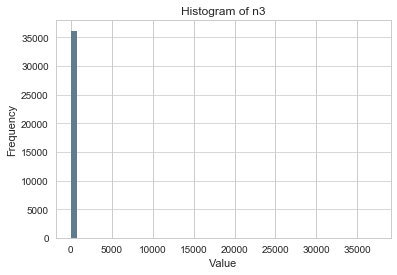

n4
[  0.   25.3  50.6  75.9 101.2 126.5 151.8 177.1 202.4 227.7 253. ]


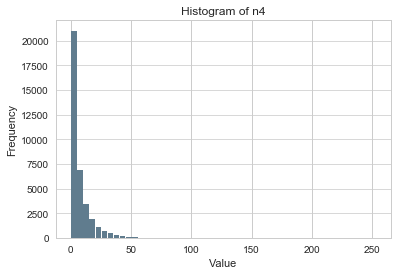

n5
[      0.   181315.8  362631.6  543947.4  725263.2  906579.  1087894.8
 1269210.6 1450526.4 1631842.2 1813158. ]


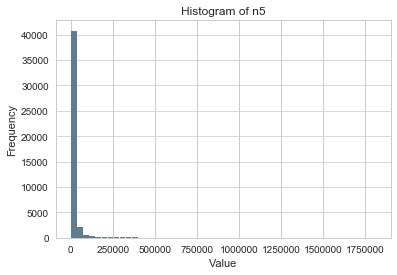

n6
[    0.   2158.5  4317.   6475.5  8634.  10792.5 12951.  15109.5 17268.
 19426.5 21585. ]


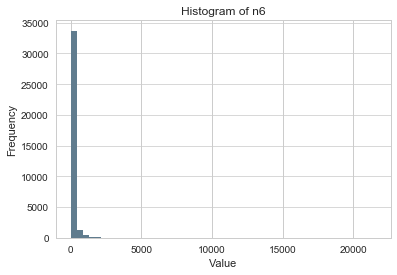

n7
[   0.   344.9  689.8 1034.7 1379.6 1724.5 2069.4 2414.3 2759.2 3104.1
 3449. ]


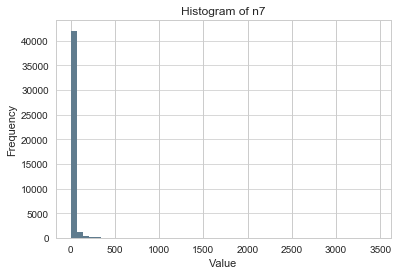

n8
[  0.   71.6 143.2 214.8 286.4 358.  429.6 501.2 572.8 644.4 716. ]


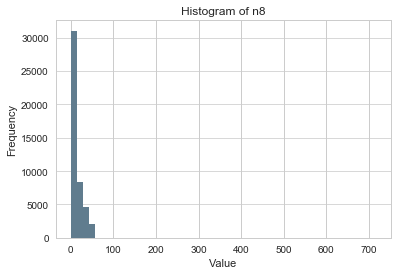

n9
[   0.   916.5 1833.  2749.5 3666.  4582.5 5499.  6415.5 7332.  8248.5
 9165. ]


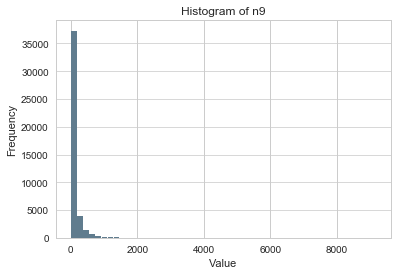

n10
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4 7.2 8. ]


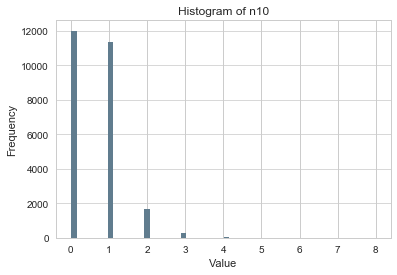

n11
[  0.   13.5  27.   40.5  54.   67.5  81.   94.5 108.  121.5 135. ]


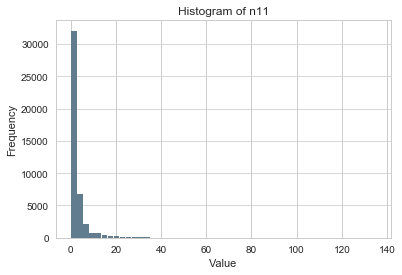

n12
[  0.  14.  28.  42.  56.  70.  84.  98. 112. 126. 140.]


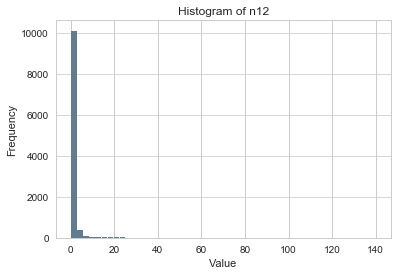

n13
[  0.  93. 186. 279. 372. 465. 558. 651. 744. 837. 930.]


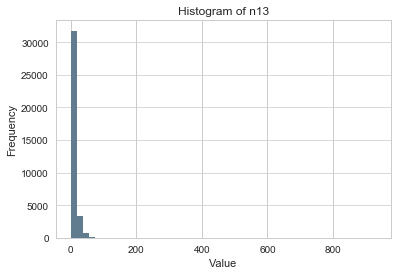

In [43]:
for i in df_integers:
    # The leftmost and rightmost bin edges
    first_edge, last_edge = df_sample[i].min(), df_sample[i].max()

    n_equal_bins = 10  # NumPy's default
    bin_edges = np.linspace(start=first_edge, stop=last_edge, num=n_equal_bins + 1, endpoint=True)
    print(i)
    print(bin_edges)
    
    # An "interface" to matplotlib.axes.Axes.hist() method
    df_sample[i].plot.hist(grid=True, bins=50, rwidth=0.9,color='#607c8e')
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of '+ str(i))
    #plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = df_sample[i].max()
    # Set a clean upper y-axis limit.
    #plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.show()

## Assessment of class dominance (imbalance) across features

Next, we examine the distribution of value counts (in percentage terms) for each of the variables. 

In [44]:
# Show top value counts for each variable
for col in df_sample.columns:
    print("Top percentage value counts for variable", col)
    print((df_sample[col].value_counts(dropna=False)/len(df_sample) * 100).head())
    print("")

Top percentage value counts for variable y
0    74.556984
1    25.443016
Name: y, dtype: float64

Top percentage value counts for variable n1
NaN    44.896630
0.0    23.269197
1.0     9.670344
2.0     5.555073
3.0     3.296560
Name: n1, dtype: float64

Top percentage value counts for variable n2
 0.0    17.273280
 1.0    15.477328
-1.0    10.343555
 2.0     5.850417
 3.0     3.118485
Name: n2, dtype: float64

Top percentage value counts for variable n3
NaN    21.345118
1.0    12.350156
2.0     8.595379
3.0     6.289090
4.0     5.255386
Name: n3, dtype: float64

Top percentage value counts for variable n4
NaN    21.703440
1.0    12.825747
2.0     9.870136
3.0     7.622481
4.0     6.130559
Name: n4, dtype: float64

Top percentage value counts for variable n5
NaN    2.406185
1.0    2.269371
0.0    1.854587
2.0    1.587474
4.0    1.144458
Name: n5, dtype: float64

Top percentage value counts for variable n6
NaN    22.320188
0.0     4.949183
1.0     2.803596
2.0     2.347550
3.0     2.08478

Several variables are dominated by select few variables (where the threshold is more than 20% dominated by one value):
- n1 is dominated by `null` values (~44% of category values);
- n3 is dominated by `null` values (~22% of category values);
- n4 is dominated by `null` values (~22% of category values);
- n6 is dominated by `null` values (~23% of category values);
- n7 is dominated by 0.0 values (~22% of category values);
- n10 is dominated by `null` values (~44% of category values);
- n11 is dominated by 1.0 values (~34% of category values);
- n12 is dominated by `null` values (~77% of category values);
- n13 is dominated by `null` values (~22% of category values);
- cat14 is dominated by `05db9164` (~50% of category values);
- cat18 is dominated by `25c83c98` (~67% of category values);
- cat20 is dominated by `0b153874` (~59% of category values); 
- cat21 is dominated by `a73ee510` (~90% of category values);
- cat30 is dominated by `e5ba7672` (~47% of category values);
- cat32 is dominated by `null` values (~44% of category values);
- cat33 is dominated by `null` values (~44% of category values);
- cat35 is dominated by `null` values (~77% of category values);
- cat36 is dominated by `32c7478e` (~44% of category values);
- cat38 is dominated by `null` values (~44% of category values);
- cat39 is dominated by `null` values (~44% of category values)

We observed that there are several features that contain a high percentage of `null` values (at least 33% `null` values). Namely, the are the features `n1`, `n10`, `n12`, `cat32`, `cat33`, `cat35`, `cat38` and `cat39`. How we treated these presented a potential challenge. For the purpose of the algorithm implemented in the subsequent section, we kept the features with high percentage null values given the predictive importance these may have. 

## Assessment of under-represented values across features

We then assess the number of distinct unique values associated with each feature in the sample dataframe. We do this in order to assess how we will perform the discretization of the categorical features and mitigate the dimensionality problem. We note that features `cat32`, `cat33`, `cat35`, `cat38` and `cat39` are particularly troublesome to produce distinct values for given the large percentage of null values.

In [45]:
# the number of distinct features associated with each feature
# use forward fill to account for missing values in some categorical variables


print("{}\t| {:10s}\t| {:10s}".format("Feature","Distinct Values","Distinct Values as a Percent of Total"))
print("="*100)
for col in df_sample.columns[0:32]:
    unique_values = len(np.unique(df_sample[col].ffill()))
    unique_values_pct = len(np.unique(df_sample[col].ffill()))/len(df_sample) * 100
    print(" {}\t| {:6d}\t\t| {:6f}".format(str(col),unique_values,unique_values_pct))

print(" {}\t| {:6d}\t\t| {:6f}".format(str('cat34'),len(np.unique(df_sample['cat34'].ffill())),len(np.unique(df_sample['cat34'].ffill()))/len(df_sample)* 100)) 
print(" {}\t| {:6d}\t\t| {:6f}".format(str('cat36'),len(np.unique(df_sample['cat36'].ffill())),len(np.unique(df_sample['cat36'].ffill()))/len(df_sample)* 100)) 
print(" {}\t| {:6d}\t\t| {:6f}".format(str('cat37'),len(np.unique(df_sample['cat37'].ffill())),len(np.unique(df_sample['cat37'].ffill()))/len(df_sample)* 100)) 

Feature	| Distinct Values	| Distinct Values as a Percent of Total
 y	|      2		| 0.004343
 n1	|    111		| 0.241053
 n2	|   1920		| 4.169562
 n3	|    441		| 0.957696
 n4	|     84		| 0.182418
 n5	|  15279		| 33.180594
 n6	|   1400		| 3.040306
 n7	|    491		| 1.066279
 n8	|     66		| 0.143329
 n9	|   1287		| 2.794910
 n10	|      9		| 0.019545
 n11	|     86		| 0.186762
 n12	|     64		| 0.138985
 n13	|    133		| 0.288829
 cat14	|    361		| 0.783965
 cat15	|    493		| 1.070622
 cat16	|  23414		| 50.846942
 cat17	|  14182		| 30.798297
 cat18	|    102		| 0.221508
 cat19	|     10		| 0.021716
 cat20	|   6375		| 13.844249
 cat21	|    180		| 0.390896
 cat22	|      3		| 0.006515
 cat23	|   8075		| 17.536049
 cat24	|   3407		| 7.398801
 cat25	|  21721		| 47.170344
 cat26	|   2612		| 5.672342
 cat27	|     24		| 0.052120
 cat28	|   4036		| 8.764767
 cat29	|  18585		| 40.360059
 cat30	|     10		| 0.021716
 cat31	|   2075		| 4.506167
 cat34	|  20394		| 44.288568
 cat36	|     13		| 0.028231
 cat37	|   74

We observe that the features `n5`, `cat16`, `cat17`, `cat20`, `cat23`, `cat25`, `cat29`, `cat34` and `cat37` are comprised of distinct values that are over 20% of total values. In other words, these features contain a large number of under-represented values. This is another potential challenge to be addressed in the algorithm implementation as it would cause high dimensionality if we were to treat each value as its own feature through non-discretionary one-hot encoding. 

In order to mitigate the dimensionality issue, we impose a criteria for one-hot encoding features for a certain threshold of distinct values. Following the reference paper, de Wit (2014), we attempt an approach of applying one-hot encoding to features with less than 3,000 and another approach applying one-hot encoding to features with over 10,000 distinct values. For features with over 3K+ and 10K+ unique values, we decide to create a stash variable that comprises the least represented values for each original feature.

You can also account for the number of distinct values of the dataframe series as follows. This will give you the column name and the cardinality (the number of elements of the set or number of distinct values for each feature).

In [65]:
# get feature and cardinality
cardinality = df_sample.apply(pd.Series.nunique)
cardinality_df = pd.DataFrame(cardinality)
cardinality_df.columns = ['Distinct_values']
cardinality_df['Distinct_values_as_pct_of_total'] = cardinality_df['Distinct_values']/len(df_sample) 
cardinality_df

,Distinct_values,Distinct_values_as_pct_of_total
y,2,0.000043
n1,111,0.002411
n2,1920,0.041696
n3,441,0.009577
n4,84,0.001824
n5,15279,0.331806
n6,1400,0.030403
n7,491,0.010663
n8,66,0.001433
n9,1287,0.027949


## Logistic regression implementation (on numeric variables)

Perform naive logistic regression on numeric variables

In [46]:
# Assign variables
y = df_sample['y']
X = df_integers

In [47]:
X.head(3)

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13
1,1.0,2.0,2.0,2.0,292.0,2.0,1.0,2.0,2.0,1.0,1.0,NaN,2.0
2,NaN,-1.0,86.0,1.0,6147.0,875.0,3.0,1.0,96.0,NaN,1.0,NaN,1.0
3,1.0,1.0,16.0,2.0,0.0,2.0,24.0,2.0,13.0,1.0,6.0,NaN,2.0


In [48]:
from sklearn.linear_model import LogisticRegression
m = LogisticRegression()
X = X.fillna(X.mean())
m.fit(X, y)

# The estimated coefficients will all be around 1:
print(m.coef_)

/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[-3.33092837e-03 -3.53417775e-05 -1.37208171e-05 -1.15863678e-02
  -8.75823610e-06 -4.26960077e-03  1.40318311e-03 -1.67462019e-02
   3.76431631e-04 -8.16314789e-04  5.76304544e-04 -5.62253456e-04
  -1.56564765e-02]]


/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Order the features by coefficient weight contributions from naive logistic regression

In [49]:
abs_weights = np.abs(m.coef_)
int_col_names = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13']
weights_df = pd.DataFrame(list(zip(int_col_names, abs_weights[0])), columns =['Feature', 'Weight']) 
weights_df.sort_values('Weight', ascending=False)

,Feature,Weight
7,n8,0.016746
12,n13,0.015656
3,n4,0.011586
5,n6,0.004270
0,n1,0.003331
6,n7,0.001403
9,n10,0.000816
10,n11,0.000576
11,n12,0.000562
8,n9,0.000376


### Load files to GCP bucket and convert to RDDs for Spark analysis

The `train.txt` and `test.txt` files were downloaded to an external hard drive and subsequently loaded into a GCP bucket. 

In [106]:
# This command streams the main data set from dropbox directly to your GCP bucket - this may take a little time (RUN THIS CELL AS IS)
#!curl -L "https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz" | gsutil cp - gs://{BUCKET}/finalproject/train.txt

In [13]:
# Do not run in the Docker container. This command puts a local file on GCP
#!gsutil cp 'train.txt' gs://{BUCKET}/finalproject/train.txt
#!gsutil cp 'train.txt' gs://danielalvarez_w261projects/finalproject/train.txt

In [12]:
# Do not run in the Docker container. This command puts a local file on GCP
#!gsutil cp 'test.txt' gs://{BUCKET}/finalproject/test.txt
#!gsutil cp 'test.txt' gs://danielalvarez_w261projects/finalproject/test.txt

In [113]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
# trainRDD = sc.textFile(f'gs://danielalvarez_w261projects/finalproject/train.txt')
# testRDD = sc.textFile(f'gs://danielalvarez_w261projects/finalproject/test.txt')

In [114]:
# print the class
# print(type(trainRDD))
# print(type(testRDD))

In [115]:
# number of rows and shape of the files
# !cat trainRDD | wc -l

In [116]:
# convert to RDDs to DataFrames
#DF = trainRDD.map(lambda x: (x.split('\t')[0], ast.literal_eval(x.split('\t')[1]))).toDF()
# from pyspark.sql.types import Row

# #here you are going to create a function
# def f(x):
#     d = {}
#     for i in range(len(x)):
#         d[str(i)] = x[i]
#     return d

# #Now populate that
# df = trainRDD.map(lambda x: Row(**f(x))).toDF()